<a href="https://colab.research.google.com/github/Ksenyff/AI/blob/main/regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Регрессионный анализ** - это набор статистических методов для оценки **взаимосвязей** между **зависимой переменной** и одной или несколькими **независимыми переменными**.

Выполнение регрессионного анализа включает следующие шаги:
- определение задачи (оценка, предсказание), определение факторов и отклика
- проведение опытов (сбор данных)
- проверка воспроизводимости опытов (G-критерий Кохрена)
- предобработка данных (нормализация, очистка данных)
- подбор класса функции регрессии
- поиск неизвестных коэффициентов регрессии
- проверка значимости коэффициентов регрессии
- проверка адекватности регрессионной модели
- интерпретация полученных результатов

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Сбор данных (синтетические данные)

Каждая из серий опытов $j$:

$$
\begin{bmatrix}
y_{j1} \\
y_{j2} \\
\vdots \\
y_{jn} \\
\end{bmatrix}
 {=}
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\cdots & \cdots \\
1 & x_n \\
\end{bmatrix}
\cdot
\begin{bmatrix}
b_0 \\
b_1 \\
\end{bmatrix}
+
\begin{bmatrix}
e_{j1} \\
e_{j2} \\
\vdots \\
e_{jn} \\
\end{bmatrix}
$$

$$
n \times 1\hspace{25pt} n \times 2 \hspace{23pt} 2 \times 1 \hspace{18pt} n \times 1
$$

In [ ]:
# @title  {"run":"auto"}

def simple_model(X, B):
  Y = np.dot(X, B)
  return Y

model = simple_model

deviation = 0.3

n = 60 # количество экспериментов

m = 6 # количество опытов в каждом эксперименте

X = np.linspace(0, 10, n).reshape((-1, 1))
X = sm.add_constant(X) # добавление 1 перед X

parameters = np.array([[1, -1]]).T
Y = np.array([np.full((m), model(np.array([xx]), parameters).flat[0]) for xx in X])
e = np.random.normal(loc=0, scale=deviation, size=Y.shape)
Y_noised = Y + e # добавление ошибки в регрессионную модель

Y_mean = np.array([np.mean(yy) for yy in Y])
Y_noised_mean = np.array([np.mean(yy) for yy in Y_noised])

## Предобработка данных

In [ ]:
data = [
    np.array(list(range(1, n + 1)), dtype=np.uint8).reshape(-1, 1), # Нумерация экспериментов
    np.delete(X, 0, 1), # Фактор №1
    np.array(['A' if x > 0.3 else 'B' for x in np.random.normal(loc=0, scale=0.5, size=(len(X)))]).reshape(-1, 1), # Фактор №2
    Y_noised, # Отклик системы
    Y_noised_mean.reshape(-1, 1) # Средний отклик системы относительно каждого эксперимента
]
df = pd.DataFrame(
    data=np.concatenate(data, axis=1),
    columns=["Trials", "Factor (X)","Factor (X_2)", *[f"Y_series_{i}" for i in range(1, m + 1)], "Y_mean"]
)
df['Trials'] = df['Trials'].astype(np.uint8)

In [ ]:
df.head()

,Trials,Factor (X),Factor (X_2),Y_series_1,Y_series_2,Y_series_3,Y_series_4,Y_series_5,Y_series_6,Y_mean
0,1,0.0,B,0.6893170603373486,0.7848643302163091,0.6895403806352282,1.0919658496106346,1.6509592428451134,1.017681291074171,0.9873880257864673
1,2,0.1694915254237288,A,0.9979060651322523,0.9519867917273597,1.3645831356079015,0.28217006908499676,1.0788540791031793,0.9343588342005931,0.9349764958093804
2,3,0.3389830508474576,B,1.4275643086384777,0.5690553557084066,1.214932050663053,1.202315809667919,0.5010077841207321,1.324180096070729,1.0398425674782197
3,4,0.5084745762711864,B,0.440254228455226,0.04590788583536304,0.6903354953138059,0.5812255316397801,0.8015815528824366,0.3449259453309473,0.4840384399095931
4,5,0.6779661016949152,B,0.4436437912145111,0.44418756397674797,0.36376927788822916,0.16832027747807163,0.3948878182669522,0.4864357158867153,0.38354074078520456


In [ ]:
print(df['Factor (X_2)'].value_counts())

Factor (X_2)
B    44
A    16
Name: count, dtype: int64


In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Trials        60 non-null     uint8 
 1   Factor (X)    60 non-null     object
 2   Factor (X_2)  60 non-null     object
 3   Y_series_1    60 non-null     object
 4   Y_series_2    60 non-null     object
 5   Y_series_3    60 non-null     object
 6   Y_series_4    60 non-null     object
 7   Y_series_5    60 non-null     object
 8   Y_series_6    60 non-null     object
 9   Y_mean        60 non-null     object
dtypes: object(9), uint8(1)
memory usage: 4.4+ KB
None
          Trials
count  60.000000
mean   30.500000
std    17.464249
min     1.000000
25%    15.750000
50%    30.500000
75%    45.250000
max    60.000000


Удаляем строки, в которых отсутствуют элементы

In [ ]:
df.dropna(inplace=True)

Удаляем дубликаты строк

In [ ]:
duplicate_rows = df.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())
if duplicate_rows.sum() > 0:
  df.drop_duplicates(inplace=True)


Number of duplicate rows: 0


Кодируем категориальные переменные

In [ ]:
# создаем отдельные столбцы для уровней категориального фактора
encoded_x2 = pd.get_dummies(df['Factor (X_2)'], prefix='Factor (X_2)', drop_first=False).astype('int')

# вставляем новые столбцы в таблицу
df = pd.concat([df, encoded_x2], axis=1)

# удаляем старый столбец с уровнями факторами
df.drop(columns=['Factor (X_2)'], inplace=True)

In [ ]:
df.head()

,Trials,Factor (X),Y_series_1,Y_series_2,Y_series_3,Y_series_4,Y_series_5,Y_series_6,Y_mean,Factor (X_2)_A,Factor (X_2)_B
0,1,0.0,0.6893170603373486,0.7848643302163091,0.6895403806352282,1.0919658496106346,1.6509592428451134,1.017681291074171,0.9873880257864673,0,1
1,2,0.1694915254237288,0.9979060651322523,0.9519867917273597,1.3645831356079015,0.28217006908499676,1.0788540791031793,0.9343588342005931,0.9349764958093804,1,0
2,3,0.3389830508474576,1.4275643086384777,0.5690553557084066,1.214932050663053,1.202315809667919,0.5010077841207321,1.324180096070729,1.0398425674782197,0,1
3,4,0.5084745762711864,0.440254228455226,0.04590788583536304,0.6903354953138059,0.5812255316397801,0.8015815528824366,0.3449259453309473,0.4840384399095931,0,1
4,5,0.6779661016949152,0.4436437912145111,0.44418756397674797,0.36376927788822916,0.16832027747807163,0.3948878182669522,0.4864357158867153,0.38354074078520456,0,1


In [ ]:
# масштабируем фактор с помощью стандартной нормализации, с нулевым мат. ожиданием и дисперсией, равной 1
scaler = StandardScaler()
cols_to_normalize = ['Factor (X)']
scaled_data = scaler.fit(df[cols_to_normalize])
df[cols_to_normalize] = scaler.transform(df[cols_to_normalize])

In [ ]:
df.head()

,Trials,Factor (X),Y_series_1,Y_series_2,Y_series_3,Y_series_4,Y_series_5,Y_series_6,Y_mean,Factor (X_2)_A,Factor (X_2)_B
0,1,-1.703420,0.6893170603373486,0.7848643302163091,0.6895403806352282,1.0919658496106346,1.6509592428451134,1.017681291074171,0.9873880257864673,0,1
1,2,-1.645677,0.9979060651322523,0.9519867917273597,1.3645831356079015,0.28217006908499676,1.0788540791031793,0.9343588342005931,0.9349764958093804,1,0
2,3,-1.587934,1.4275643086384777,0.5690553557084066,1.214932050663053,1.202315809667919,0.5010077841207321,1.324180096070729,1.0398425674782197,0,1
3,4,-1.530191,0.440254228455226,0.04590788583536304,0.6903354953138059,0.5812255316397801,0.8015815528824366,0.3449259453309473,0.4840384399095931,0,1
4,5,-1.472448,0.4436437912145111,0.44418756397674797,0.36376927788822916,0.16832027747807163,0.3948878182669522,0.4864357158867153,0.38354074078520456,0,1


## Проверка воспроизводимости опытов

С целью проверки отклонений отклика от его среднего значения для каждого эксперимента вычисляется дисперсия эксперимента по данным $m$ повторений опытов:
$$
s^2(y_j)=\sum_{i=1}^{m}{\frac{(y_{ij}-\bar{y_j})^2}{m-1}}
$$


In [ ]:
def get_trial_deviation(Y_j):
  y_j_mean = Y_j.mean()
  m = len(Y_j)
  return np.sum(np.array([(y_ij - y_j_mean) ** 2 for y_ij in Y_j])) / (m - 1)

In [ ]:
print(f'Отклонение отклика для каждого эксперимента из {m} опытов:', [get_trial_deviation(Y_j) for Y_j in Y_noised])

Отклонение отклика для каждого эксперимента из 6 опытов: [np.float64(0.13415126613991699), np.float64(0.12713374341486816), np.float64(0.16004267656118165), np.float64(0.07321303203957419), np.float64(0.012943460894774963), np.float64(0.0294792986103125), np.float64(0.12741558676152215), np.float64(0.0421891730626832), np.float64(0.21877558645144268), np.float64(0.19956691456684875), np.float64(0.11289767185437027), np.float64(0.15070162536955306), np.float64(0.07267603774455736), np.float64(0.04312898622140916), np.float64(0.19662858371917444), np.float64(0.11973730488770537), np.float64(0.08154361842524985), np.float64(0.23391409278409475), np.float64(0.08554051726630843), np.float64(0.053199311210572774), np.float64(0.04029104814040232), np.float64(0.05568947443647624), np.float64(0.07893465680315463), np.float64(0.05554443323302971), np.float64(0.023681054304203246), np.float64(0.1131519412781438), np.float64(0.12382779088437483), np.float64(0.02617736344513068), np.float64(0.11460

Среди всех вычисленных дисперсий находится максимальное и вычисляется отношение этой дисперсии к сумме всех дисперсий или **коэффициент Кохрена**:
$$
G_p=\frac{s^2(y_j)_{max}}{\sum_{j=1}^{n}{s^2(y_j)}}
$$

При идеальной однородности дисперсий $G_p=\frac{1}{n}$

Значение коэффициента сравнивается с табличным значением $G_т$ критерия, которое выбирается, исходя из уровня значимости $\alpha$, количества экспериментов $f_2=n$ и кол-ва опытов в каждом эксперименте $f_1=m-1$

Если расчетное значение коэффициента Кохрена меньше табличного: $G_p < G_т$ для уровня статистической значимости $\alpha$, то все построчные дисперсии признаются однородными. В противном случае необходимо провести дополнительные опыты.

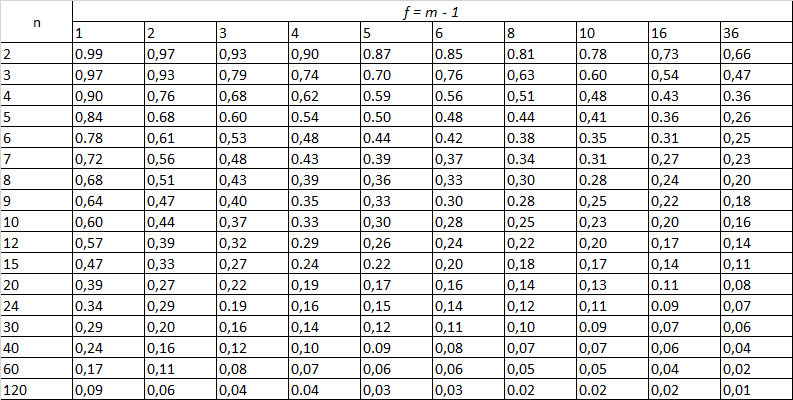

In [ ]:
def kochran_test(Y):
  deviations = np.array([get_trial_deviation(Y_j) for Y_j in Y])
  return deviations.max() / np.sum(deviations)

In [ ]:
print(f'Значение коэффициента Кохрена для n={n} и f=m-1={m-1}:', kochran_test(Y_noised))

Значение коэффициента Кохрена для n=60 и f=m-1=5: 0.045989101518827694


Если все дисперсии экспериментов однородны, вычисляется дисперсия воспроизводимости $s_{y}^{2}$, характеризующую ошибку всего эксперимента:
$$
s_{y}^{2}=\frac{1}{n\cdot (m-1)}\sum_{j=1}^{n}{\sum_{i=1}^{m}{(y_{ij}-\bar{y_j})^2}}=\frac{\sum_{j=1}^{n}{s^2(y_j)}}{n}
$$

In [ ]:
def get_general_deviation(Y):
  n = len(Y)
  deviations = np.array([get_trial_deviation(Y_j) for Y_j in Y])
  return np.sum(deviations) / n

In [ ]:
print(f'Ошибка эксперимента для n={n} и f=m-1={m-1}:', get_general_deviation(Y_noised))

Ошибка эксперимента для n=60 и f=m-1=5: 0.08477156726952348


## Выбор класса функции регрессии
Рассмотрение различных функций на на базе синтетических данных с шумами

In [ ]:
def draw_points_and_source_model(X, Y, Y_noised, projection=None):

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1, projection=projection)
  plt.title('Точки данных')
  plt.plot(*X, Y_noised, marker='o', linewidth=0)

  plt.subplot(1, 3, 2, projection=projection)
  plt.title('Исходная функция')
  plt.plot(*X, Y, c='r', linewidth=3)

  plt.subplot(1, 3, 3, projection=projection)
  plt.title('Исходная функция на точках данных')
  plt.plot(*X, Y_noised, marker='o', linewidth=0)
  plt.plot(*X, Y, c='r', linewidth=3)

  plt.tight_layout()
  plt.show()

### Простая регрессия

Простая линейная регрессия описывается следующим уравнением:

$$
f(x) = b_0 + b_1x
$$

Матричный вид:

$$
f(X)
 {=}
\begin{bmatrix}
1 & x \\
\end{bmatrix}
\times
\begin{bmatrix}
b_0 \\
b_1 \\
\end{bmatrix}
$$

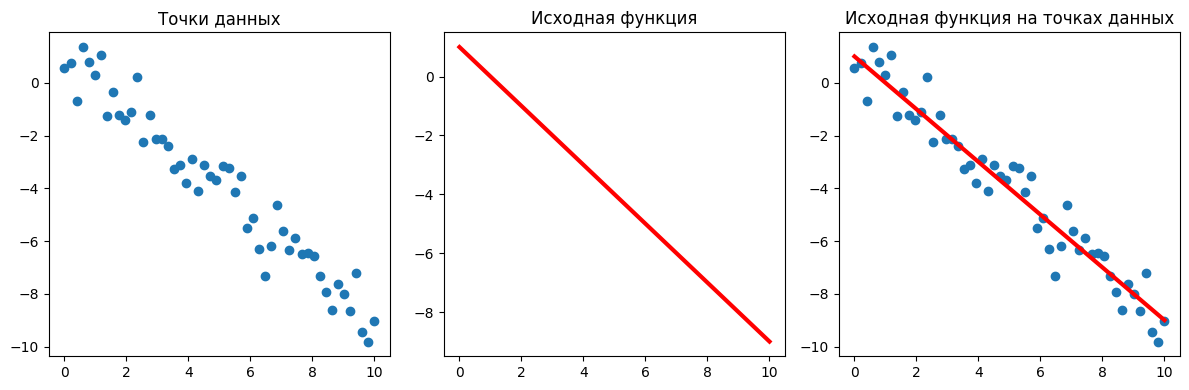

In [ ]:
#  описываем нашу простую модель
def simple_model(X, B):
  Y = np.dot(X, B)
  return Y

model = simple_model

deviation = 0.75
data_count = 52
X = np.linspace(0, 10, data_count).reshape((-1, 1))

parameters = np.array([[1, -1]]).T
Y = np.array([model(np.array([[1, *xx]]), parameters).flat[0] for xx in X])
e = np.random.normal(loc=0, scale=deviation, size=Y.shape)
Y_noised = Y + e

draw_points_and_source_model(X.T, Y, Y_noised)

### Простая множественная регрессия

Простая линейная множественная регрессия описывается следующим уравнением:

$$
f(x_0, x_1, ..., x_n) = b_0 + b_1x_0 + b_2x_1 + ... +  b_{n+1}x_n
$$

Матричный вид:

$$
f(X)
 {=}
\begin{bmatrix}
1 & x_0 & x_1 & \cdots & x_n \\
\end{bmatrix}
\times
\begin{bmatrix}
b_0 \\
b_1 \\
\vdots \\
b_{n+1} \\
\end{bmatrix}
$$

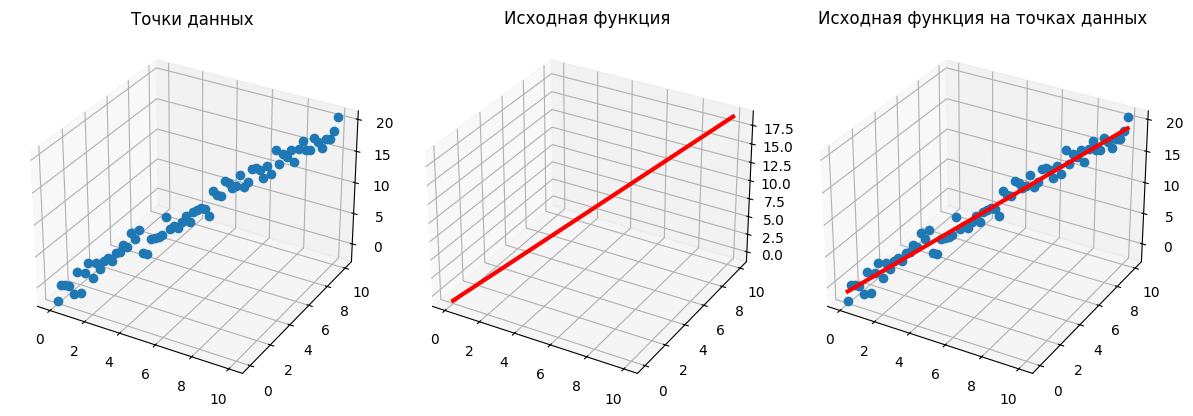

In [ ]:
# @title  {"run":"auto"}
#  описываем множественную модель
def multiple_model(X, B):
  Y = np.dot(X, B)
  return Y

model = multiple_model

deviation = 1.1 # @param {type:"slider", min:0, max:3, step:0.05}
data_count = 73 # @param {type:"slider", min:5, max:200, step:1}

X_1 = np.linspace(0, 10, data_count)
X_2 = np.linspace(0, 10, data_count)
X = np.column_stack((X_1,X_2))

parameters = np.array([-1, 1, 1]).T
Y = np.array([model(np.array([[1, *xx]]), parameters).flat[0] for xx in X])
e = np.random.normal(loc=0, scale=deviation, size=Y.shape)
Y_noised = Y + e

draw_points_and_source_model(X.T, Y, Y_noised, projection='3d')

### Полиномиальная регрессия

Линейная регрессия алгебраическим многочленом (полиномиальная регрессия) описывается следующим уравнением:

$$
f(x) = b_0 + b_1x + b_2x^2 + ... +  b_{n+1}x^n
$$

Матричный вид:

$$
f(X)
 {=}
\begin{bmatrix}
1 & x & x^2 & \cdots & x^n \\
\end{bmatrix}
\times
\begin{bmatrix}
b_0 \\
b_1 \\
\vdots \\
b_{n+1} \\
\end{bmatrix}
$$

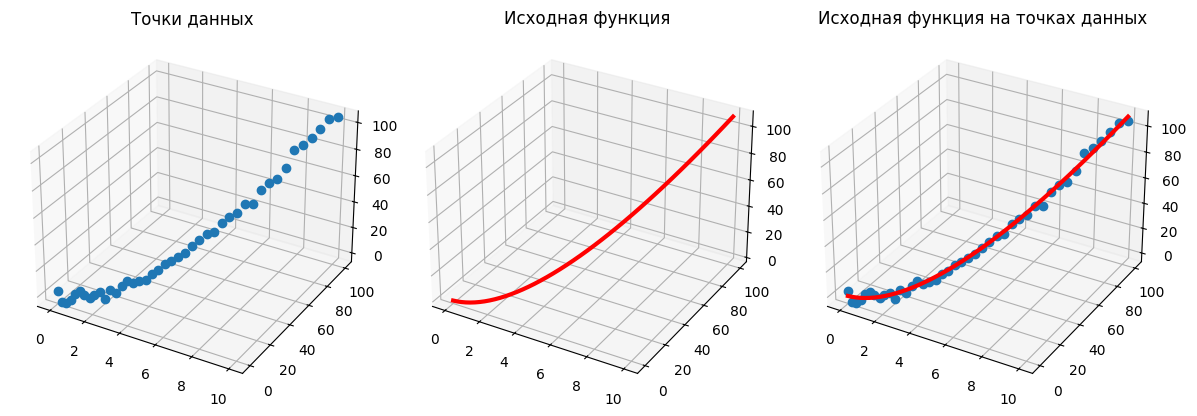

In [ ]:
# @title  {"run":"auto"}
#  описываем множественную модель
def polynomial_model(X, B):
  Y = np.dot(X, B)
  return Y

model = polynomial_model

deviation = 3 # @param {type:"slider", min:0, max:3, step:0.05}
data_count = 43 # @param {type:"slider", min:5, max:200, step:1}

X_1 = np.linspace(0, 10, data_count)
X_2 = np.linspace(0, 10, data_count)
X_2 = np.power(X_2, 2)
X = np.column_stack((X_1,X_2))

parameters = np.array([-1, 1, 1]).T
Y = np.array([model(np.array([[1, *xx]]), parameters).flat[0] for xx in X])
e = np.random.normal(loc=0, scale=deviation, size=Y.shape)
Y_noised = Y + e

draw_points_and_source_model(X.T, Y, Y_noised, projection='3d')

### Логистическая регрессия

Линейная логистическая регрессия описывается следующим уравнением:

$$
f(x) = \frac{1}{1 + e^{-(b_0 + b_1x)}}
$$

Матричный вид:

$$
f(X) = \frac{1}{1 + e^{-(X \times B)}}
$$

Где

$$
X = \begin{bmatrix}
1 & x_0 & x_1 & \cdots & x_n \\
\end{bmatrix}
,
B =
\begin{bmatrix}
b_0 \\
b_1 \\
\vdots \\
b_{n+1} \\
\end{bmatrix}
$$

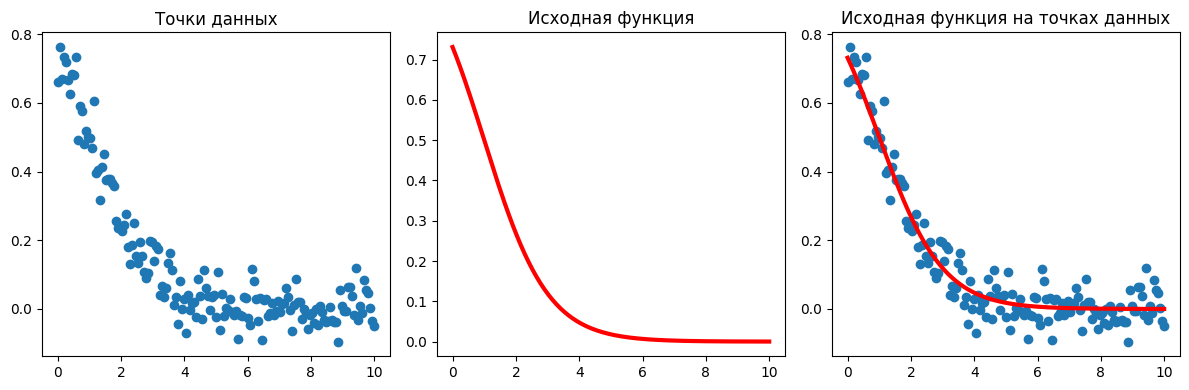

In [ ]:
#  описываем логистическую регрессионную модель
def logistic_model(X, B):
  Y = 1 / (1 + np.e ** -(np.dot(X, B)))
  return Y

model = logistic_model

deviation = 0.05 # @param {type:"slider", min:0, max:3, step:0.05}
data_count = 159 # @param {type:"slider", min:5, max:200, step:1}

X = np.linspace(0, 10, data_count).reshape((-1, 1))

parameters = np.array([[1, -1]]).T
Y = np.array([model(np.array([[1, *xx]]), parameters).flat[0] for xx in X])
e = np.random.normal(loc=0, scale=deviation, size=Y.shape)
Y_noised = Y + e

draw_points_and_source_model(X.T, Y, Y_noised)

## Вычисление неизвестных коэффициентов

Вычисление неизвестных коэффициентов выполняется с помощью метода наименьших квадратов (англ. least squares (LS)), заключающегося в минимизации суммы квадратов остатков (англ. sum of squared residuals (SSR)):

$$
S(X, B) = \sum_{i=0}^{n}{(y_i-f(X_i, B))^2}
$$

In [ ]:
def draw_predicted_and_source_model(X, Y, Y_noised, Y_best_fit, projection=None):

  plt.figure(figsize=(16, 4))
  xlim, ylim = [-1, 11], [-13, 7]

  ax1 = plt.subplot(1, 4, 1, projection=projection)
  ax1.set_title('Исходная функция')
  ax1.set_xlim(xlim)
  ax1.set_ylim(ylim)
  ax1.plot(*X, Y, c='b', linewidth=3)

  ax2 = plt.subplot(1, 4, 2, projection=projection)
  ax2.set_title('Точки данных')
  ax2.set_xlim(xlim)
  ax2.set_ylim(ylim)
  ax2.plot(*X, Y, c='b', label='Исходная функция', linewidth=3)
  ax2.scatter(*X, Y_noised, s=10, label='Точки данных')
  ax2.legend(loc='best')

  ax3 = plt.subplot(1, 4, 3, projection=projection)
  ax3.set_title('Регрессионная модель')
  ax3.set_xlim(xlim)
  ax3.set_ylim(ylim)
  ax3.scatter(*X, Y_noised, s=10, label='Точки данных')
  ax3.plot(*X, Y, c='b', label='Исходная функция', linewidth=2, alpha=0.4)
  ax3.plot(*X, Y_best_fit, c='r', linewidth=2, label='Регрессионная модель')
  ax3.legend(loc='best')

  ax4 = plt.subplot(1, 4, 4, projection=projection)
  ax4.set_title('Ошибки регрессионной модели')
  ax4.set_xlim(xlim)
  ax4.set_ylim(ylim)
  ax4.scatter(*X, Y_noised, s=10, label='Точки данных')
  ax4.plot(*X, Y_best_fit, c='r', linewidth=2, label='Регрессионная модель')
  ax4.vlines(*X, Y_best_fit, Y_noised)
  ax4.legend(loc='best')

  plt.tight_layout()
  plt.show()

### Генерируем данные и накладываем шум

In [ ]:
# @title  {"run":"auto"}

model = simple_model

deviation = 0.9 # @param {type:"slider", min:0, max:3, step:0.05}
n = 60 # @param {type:"slider", min:5, max:200, step:1}
m = 6

X = np.linspace(0, 10, n).reshape((-1, 1))
X = sm.add_constant(X)

parameters = np.array([[1, -1]]).T
Y = np.array([np.full((m), model(np.array([xx]), parameters).flat[0]) for xx in X])
e = np.random.normal(loc=0, scale=deviation, size=Y.shape)
Y_noised = Y + e

Y_mean = np.array([np.mean(yy) for yy in Y])
Y_noised_mean = np.array([np.mean(yy) for yy in Y_noised])

### Вычисляем неизвестные коэффициенты для простой линейной регрессии

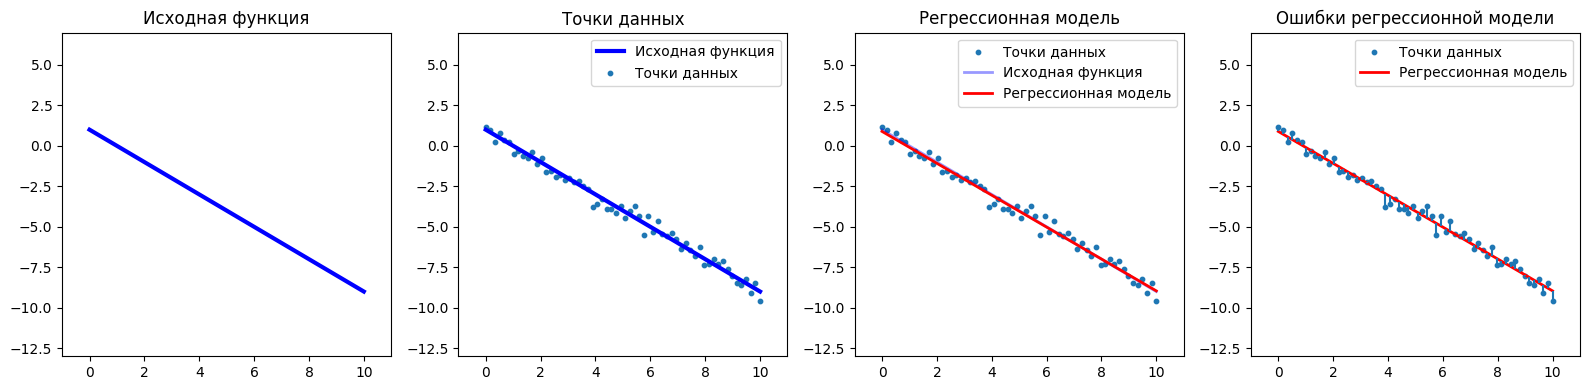

In [ ]:
clf = LinearRegression(fit_intercept=True)
clf.fit(np.delete(X, 0, 1),Y_noised_mean)
Y_pred = clf.predict(np.delete(X, 0, 1))


draw_predicted_and_source_model(np.delete(X, 0, 1).T, Y_mean, Y_noised_mean, Y_pred)

In [ ]:
clf.coef_, clf.intercept_

(array([-0.98520603]), np.float64(0.8920260323755622))

## Проверка значимости коэффициентов (параметров) регрессии

Одним из способов проверки значимости коэффициентов является t-критерий Стьюдента. Расчетное значение t-критерия рассчитывается как частное от деления **значения коэффициента**, взятое по модулю, на оценку **среднеквадратического отклонения этого коэффициента**:

$$
t_k = \frac{|b_k|}{s_{коэф}}
$$

Проверка заключается в подтверждении нулевой гипотезы $H_0$ о том, что коэффициент $b_k$ значим: $t_k \geq t_{cr}$

Альтернативной гипотезой $H_1$ является утверждение о том, что коэффициент $b_k$ не значим: $t_k < t_{cr}$

где $t_{cr}$ - табличное значение из таблицы критических точек распределения Стьюдента для кол-ва опытов, равному $n$ и кол-ва коэффициентов, равному $m$

Среднее квадратичное отклонение коэффициентов $s_{коэф}$ равно
$$
s_{коэф}=\sqrt{\frac{s_y^2}{m \cdot n}}
$$

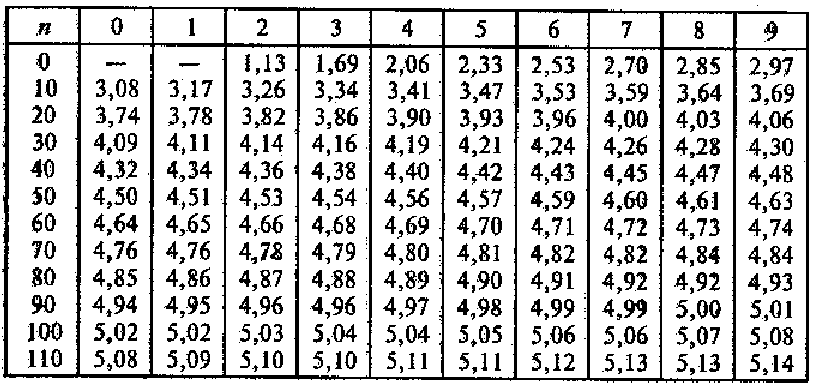

In [ ]:
def get_coef_deviation(Y):
  n, m = Y.shape
  return np.sqrt(get_general_deviation(Y) / (m * n))

In [ ]:
print(f'Среднее квадратическое отклонение коэффициентов:', get_coef_deviation(Y_noised))

Среднее квадратическое отклонение коэффициентов: 0.04917446542205022


In [ ]:
def get_coef_significance(Y, coef):
  return np.abs(coef) / get_coef_deviation(Y)

In [ ]:
print(f'Значение расчетного значения t-критерия значимости коэффициентов для n={n}, m={m}:', [get_coef_significance(Y_noised, coef) for coef in np.concatenate([np.array([clf.intercept_]), clf.coef_])])

Значение расчетного значения t-критерия значимости коэффициентов для n=60, m=6: [np.float64(18.140025005245317), np.float64(20.03491093164057)]


## Проверка адекватности построенной регрессионной модели

Проверка на адеватность регрессионной модели проводится с помощью критерия Фишера $F_{расч}$:
$$
F_{расч}=\frac{s_{ост}^2}{s_{y}^2}
$$
где $s_{y}^2$ - дисперсия воспроизводимости, $s_{ост}^2$ - остаточная дисперсия

Остаточная дисперсия вычисляется по формуле
$$
s_{ост}^2 = \frac{m}{n-r}\sum_{j=1}^{n}{(\hat{y_j} - \bar{y_j})^2}
$$
где $n$ - количество экспериментов, $m$ - кол-во опытов в каждом эксперименте, $r$ - число значимых коэффициентов в уравнении регрессии, $\hat{y_j}$ - значение отклика, полученное из регрессионной модели со значимыми коэффициентами для $j$-го эксперимента, $\bar{y_j}$ - среднее значение отклика для $j$-го эксперимента

В случае, если $F_{расч}<F_{табл}$, уравнение считается адекватным, в противном случае, при $F_{расч}\geq F_{табл}$ - неадекватным

Табличное значение критерия $F_{табл}$ находится в таблице критических точек распределения Фишера по заданному уровню значимости $\alpha$ и степеням свободы $k_1=n-r$ и $k_2=n(m-1)$

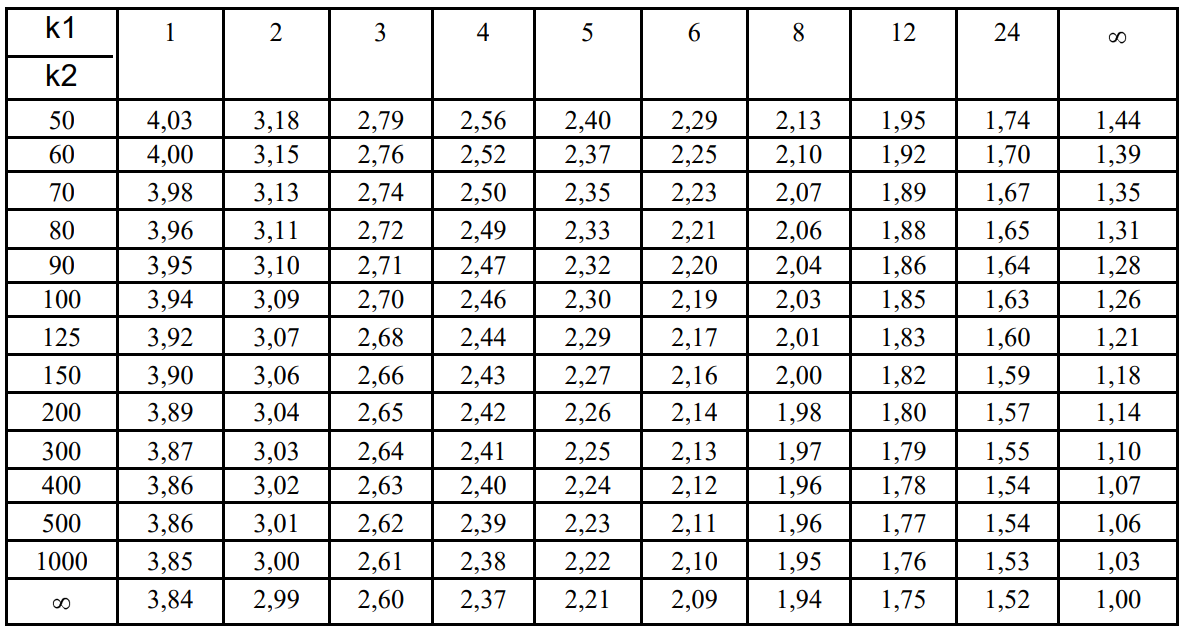

In [ ]:
def get_residual_deviation(Y_pred, Y_mean, params):
  n, m, r = params
  deviations = np.array([(y_pred_j - y_mean_j) ** 2 for y_pred_j, y_mean_j in zip(Y_pred, Y_mean)])
  return (m / (n - r)) * np.sum(deviations)

In [ ]:
def get_f_stat(Y, Y_pred, Y_mean, params):
  return get_residual_deviation(Y_pred, Y_mean, params) / get_general_deviation(Y)

In [ ]:
n, m, r = *Y_noised.shape, 2
print(f'Расчетное значение критерия Фишера для k_1={n-r} и k_2={n*(m-1)}:', get_f_stat(Y_noised, Y_pred, Y_noised_mean, (n, m, r)))

Расчетное значение критерия Фишера для k_1=58 и k_2=300: 0.860039776184201
